# pizza-pasta-classifier
Author: Georgia Gunson

Function: A machine learning pipeline for the classification of pizza and pasta containing dishes.

Images were defined as containing 'pizza' or 'pasta' based on the presence of corresponding string terms in the 'Ingredients' or 'Dish name' attributes of the CSV file. Of the original set of 3250 images, 96 were identified to contain pizza, and 146 to contain pasta. To facilitate model training, these labels were encoded numerically, assigning 0 to pasta and 1 to pizza. While the classes are imbalanced, this difference was relatively small and not postulated to affect model class accuracies.


In [ ]:
# Install packages where required
!pip install spkit

# Load libraries
import os
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import spkit as sp

from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score
from sklearn.pipeline import make_pipeline

from skimage import color, filters, feature

from scipy.stats import skew
import cv2

from joblib import Parallel, delayed


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.2 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
# Set working directory
os.chdir('/content/drive/MyDrive/Data/MLEnd/yummy/')

# Read in the csv file
MLENDYD_df = pd.read_csv('/content/drive/MyDrive/Data/MLEnd/yummy/MLEndYD_image_attributes_benchmark.csv').set_index('filename')

# Get pizza data
pizza_df = MLENDYD_df.loc[(MLENDYD_df['Dish_name'].str.contains('pizza', case=False, na=False)) | (MLENDYD_df['Ingredients'].str.contains('pizza', case=False, na=False))].copy()
# Add pizza label
pizza_df['Pizza_Pasta'] = 'pizza'
print(len(pizza_df), "pizza rows")

# Get pasta data
pasta_df = MLENDYD_df.loc[(MLENDYD_df['Dish_name'].str.contains('pasta', case=False, na=False)) | (MLENDYD_df['Ingredients'].str.contains('pasta', case=False, na=False))].copy()
# Add pasta label
pasta_df['Pizza_Pasta'] = 'pasta'
print(len(pasta_df), "pasta rows")

# Join data together
MLEND_pp_df = pd.concat([pizza_df, pasta_df], ignore_index=False)

# Encode the pizza pasta label
# Encode the Rice =1  and Chips=0 instead of string labels
encoder = LabelEncoder()
MLEND_pp_df['Pizza_Pasta_encoded'] = encoder.fit_transform(MLEND_pp_df['Pizza_Pasta'])

# Get value counts, pasta = 0, pizza = 1
MLEND_pp_df['Pizza_Pasta_encoded'].value_counts()

# Split the data into training and 10% test sets, ensure balance of classes
# the 90% train data will go on to k-cross validation
train_data, test_data  = train_test_split(MLEND_pp_df['Pizza_Pasta_encoded'], test_size=0.1, stratify=MLEND_pp_df['Pizza_Pasta_encoded'].values, random_state=42)

# Get the image paths and labels of the training and test dataset
X_train_paths = train_data.reset_index()['filename']
X_test_paths  = test_data.reset_index()['filename']

Y_train = train_data.reset_index()['Pizza_Pasta_encoded']
Y_test  = test_data.reset_index()['Pizza_Pasta_encoded']


96 pizza rows
146 pasta rows


In [ ]:
# Functions to make image proportions uniform (shape and size)
filepath_images = '/content/drive/MyDrive/Data/MLEnd/yummy/MLEndYD_images/'

# Custom function to make image shape square by including black pizels
def make_it_square(I, pad=0):
    # Get the dimensions of the input image
    # C represents the number of colour channels
    N, M, C = I.shape

    # Check if the number of rows (N) is greater than the number of columns (M)
    if N > M:
        # If N > M, pad the image to make it square by adding black pixels to the right
        Is = [np.pad(I[:,:,i], [(0,0), (0, N-M)], 'constant', constant_values=pad) for i in range(C)]
    else:
        # If M >= N, pad the image to make it square by adding black pixels to the bottom
        Is = [np.pad(I[:,:,i], [(0, M-N), (0,0)], 'constant', constant_values=pad) for i in range(C)]

    # Combine the padded channels and transpose the result
    return np.array(Is).transpose([1, 2, 0])

# Cutom function to resize the image to 200 by 200 pixel
def resize_img(I, size=[200, 200]):
    # Get the dimensions of the input image
    N, M, C = I.shape

    # Resize each channel of the image independently
    Ir = [sp.core.processing.resize(I[:,:,i], size) for i in range(C)]

    # Combine the resized channels and transpose the result
    return np.array(Ir).transpose([1, 2, 0])


# Custom function to calculate sobel magnitude
def calculate_sobel_magnitude(I):

  # Convert to grey image
  grey_image = cv2.cvtColor((I * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

  # Calculate sobel gradients
  sobel_x = cv2.Sobel(grey_image, cv2.CV_64F, 1, 0, ksize=5)
  sobel_y = cv2.Sobel(grey_image, cv2.CV_64F, 0, 1, ksize=5)
  sobel_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)

  # Return the magnitude alone
  return sobel_magnitude

# Custom function to process each image
# Input is file path
# Outputs is numpy array of the histograms for a* and b* channels, sobel magnitude and entropy
def process_image(file):
    I = plt.imread(filepath_images + file)
    I = make_it_square(I, pad=0)
    I = resize_img(I, size=[200, 200])

    # Get sobel mag
    sobel_magnitude = calculate_sobel_magnitude(I)

    # Convert to CIE L*a*b* colourspace
    I_lab = color.rgb2lab(I / 255.0)
    I_ab = I_lab[:, :, 1:]

    # Flatten the a* and b* channels
    ab_flat = I_ab.reshape(-1, 2)

    # Concatenate a* and b* channels with sobel magnitude
    features = np.concatenate([ab_flat.flatten(), np.array([sobel_magnitude]).flatten()])

    return features

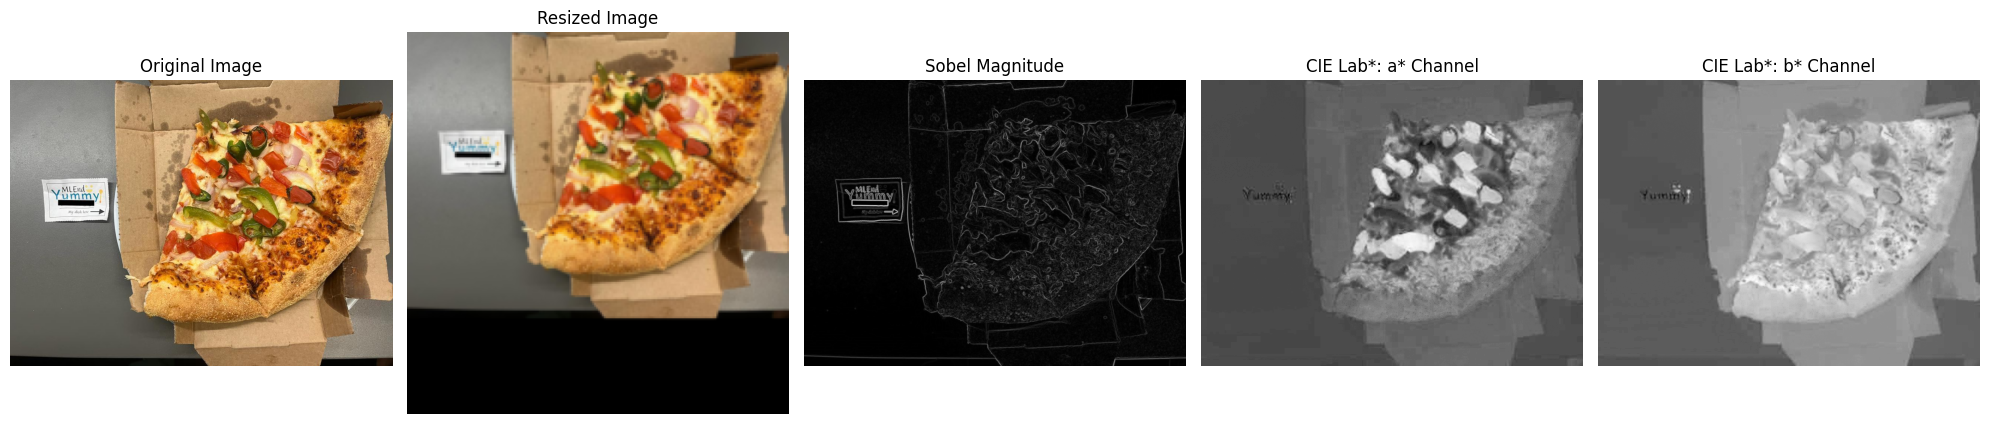

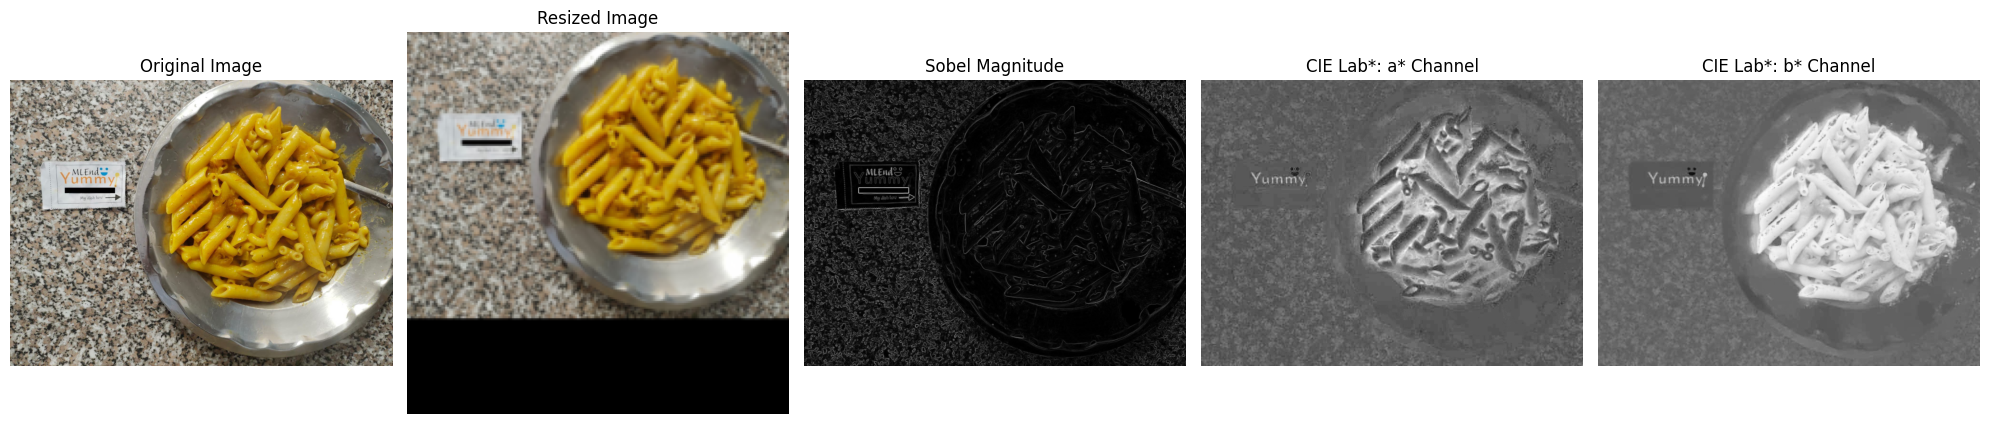

In [ ]:
# Get image examples of both classes
example_pizza = MLEND_pp_df.loc[MLEND_pp_df['Pizza_Pasta_encoded']==1].index[0]
example_pizza = filepath_images + example_pizza
example_pasta = MLEND_pp_df.loc[MLEND_pp_df['Pizza_Pasta_encoded']==0].index[0]
example_pasta = filepath_images + example_pasta
example_images = [example_pizza, example_pasta]

# Custom function to compare original,resized, sobel magnitude, a* and b* channels images
def show_features(image_path):
    # Load original image
    original_image = cv2.imread(image_path)
    original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # Make the image square
    square_image = make_it_square(original_image_rgb, pad=0)

    # Resize the image
    resized_image = resize_img(square_image, size=[200, 200])

    # Convert to greyscale
    grey_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

    # Calculate Sobel gradients
    sobel_x = cv2.Sobel(grey_image, cv2.CV_64F, 1, 0, ksize=5)
    sobel_y = cv2.Sobel(grey_image, cv2.CV_64F, 0, 1, ksize=5)
    sobel_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)

    # Convert to CIE Lab* colorspace
    lab_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2Lab)

    # Split into channels
    _, lab_a_channel, lab_b_channel = cv2.split(lab_image)

    # Show the images
    plt.figure(figsize=(20, 5))

    # Original
    plt.subplot(1, 5, 1)
    plt.imshow(original_image_rgb)
    plt.title('Original Image')
    plt.axis('off')

    # Resized
    plt.subplot(1, 5, 2)
    plt.imshow(resized_image)
    plt.title('Resized Image')
    plt.axis('off')

    # Sobel
    plt.subplot(1, 5, 3)
    plt.imshow(sobel_magnitude, cmap='gray')
    plt.title('Sobel Magnitude')
    plt.axis('off')

    # a*
    plt.subplot(1, 5, 4)
    plt.imshow(lab_a_channel, cmap='gray')
    plt.title('CIE Lab*: a* Channel')
    plt.axis('off')

    # b*
    plt.subplot(1, 5, 5)
    plt.imshow(lab_b_channel, cmap='gray')
    plt.title('CIE Lab*: b* Channel')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Show images
for image_path in example_images:
    show_features(image_path)

Visual representation of pizza and pasta images with extracted image features are above. The images, in order, include the original RGB image, the image resized to 200x200 and made square, the Sobel magnitude representing edge gradients, the a* channel of the CIE Lab* colorspace capturing values on a green to red axis, and the b* channel capturing colour values on a blue to yellow axis. For ease of visual comparison, the sobel magnitude and colour channel images have not been resized.

In [ ]:
# Process images in parallel
num_cores = -1
# This takes ~13 minutes to run, not ideal (apologies) but fewer features (colour histograms, mean, std, skew) has worse performance
X_train_features = Parallel(n_jobs=num_cores)(delayed(process_image)(file) for file in X_train_paths)

# Convert the list of features to a numpy array
X_train_features = np.array(X_train_features)

# Display the shape of the training set
print("Training set shape:", X_train_features.shape)


Training set shape: (217, 120000)


In [ ]:
# Extract features of test dataset
# Should take ~2 mins
X_test_features = Parallel(n_jobs=num_cores)(delayed(process_image)(file) for file in X_test_paths)

# Convert to numpy array
X_test_features = np.array(X_test_features)

# Display shape of test set
print("Test set shape:", X_test_features.shape)

Test set shape: (25, 120000)


Following feature extraction above, there is a high dimensional feature space of 120000 attributes per image. Using this number of features in the SVM model poses a strong risk of overfitting it to the training data, with poor generalisation. To mitigate this, PCA is used to reduce dimensionality.

In [ ]:
# Standardize features
scaler = StandardScaler()
X_train_features_standardized = scaler.fit_transform(X_train_features)
X_test_features_standardized = scaler.transform(X_test_features)

# PCA
# Define components
num_components = 15
pca = PCA(n_components=num_components)
X_train_pca = pca.fit_transform(X_train_features_standardized)
X_test_pca = pca.transform(X_test_features_standardized)

# Get variance ratio per component for training set
var_ratio_train = pca.explained_variance_ratio_
print("Explained Variance Ratio (Training data):", var_ratio_train)

# Confirm new shape for training set
print("PCA-transformed Training set shape:", X_train_pca.shape)

# Get total amount of variance explained for training set
print("Sum of Explained Variance Ratio (Training data):", np.sum(var_ratio_train))

# Get variance ratio per component for test set
var_ratio_test = pca.explained_variance_ratio_
print("Explained Variance Ratio (Test data):", var_ratio_test)

# Confirm new shape for test set
print("PCA-transformed Test set shape:", X_test_pca.shape)

# Get total amount of variance explained for test set
print("Sum of Explained Variance Ratio (Test data):", np.sum(var_ratio_test))


Explained Variance Ratio (Training data): [0.11097221 0.08833592 0.05600822 0.04345553 0.0371741  0.0311736
 0.02664023 0.01774204 0.01729325 0.01587666 0.0150034  0.01292915
 0.01185982 0.01054399 0.01001652]
PCA-transformed Training set shape: (217, 15)
Sum of Explained Variance Ratio (Training data): 0.5050246456438438
Explained Variance Ratio (Test data): [0.11097221 0.08833592 0.05600822 0.04345553 0.0371741  0.0311736
 0.02664023 0.01774204 0.01729325 0.01587666 0.0150034  0.01292915
 0.01185982 0.01054399 0.01001652]
PCA-transformed Test set shape: (25, 15)
Sum of Explained Variance Ratio (Test data): 0.5050246456438438


All features were standardised prior to PCA due to its scale sensitivity; features with larger magnitudes can dominate the principal components. The sum of the explained variance ratios was used as a metric to inform the choice of the number of components. The number of components attempted to balance parameter reduction with the loss of image information. Above, 15 principle components, describing 50% of the total variation in both the test and training datasets were chosen as inputs to the classifier. This sum ratio is a much smaller than desired; target values would demonstrate that the majority of the variation in the dataset is captured in those principle components. However, additional components wages the risk of overfitting in the model. Further exploration of this is recommended in future.

The final training and test datasets are comprised of 217 and 25 samples respectively, with 15 features representing the first 15 principle components of the extracted features, standardised.


# 8 Results


In [ ]:
# Create SVM models with different kernels
svm_linear = make_pipeline(SVC(kernel='linear'))
svm_poly2 = make_pipeline(SVC(kernel='poly', degree=2))
svm_poly3 = make_pipeline(SVC(kernel='poly', degree=3))
svm_poly4 = make_pipeline(SVC(kernel='poly', degree=4))
svm_poly5 = make_pipeline(SVC(kernel='poly', degree=5))

# List all models
models = [svm_linear, svm_poly2, svm_poly3, svm_poly4, svm_poly5]

# Create KFold cross-validation object
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Empty list to store results
results = []

# For each model
for model in models:
    # Create a pipeline with current SVM model
    pipeline = make_pipeline(model)

    # Create empty lists to store predicted vs actual vals
    y_true, y_pred = [], []

    # For each fold
    for train_index, test_index in kf.split(X_train_pca):
        # Get that fold's data
        X_train_fold, X_test_fold = X_train_pca[train_index], X_train_pca[test_index]
        y_train_fold, y_test_fold = Y_train[train_index], Y_train[test_index]

        # Fit model
        pipeline.fit(X_train_fold, y_train_fold)

        # Make predictions
        y_true.extend(y_test_fold)
        y_pred.extend(pipeline.predict(X_test_fold))

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')

    # Get model information
    model_name = model.steps[-1][1].kernel.capitalize()
    kernel = model.steps[-1][1].kernel
    degree = model.steps[-1][1].degree if kernel == 'poly' else ''

    # Collect all results
    results.append([model_name, kernel, degree, accuracy, precision, recall])

# Put all results in table to compare
columns = ['Model', 'Kernel', 'Degree', 'Accuracy', 'Precision', 'Recall']
results_df = pd.DataFrame(results, columns=columns)

# Display the DataFrame
display(results_df)


,Model,Kernel,Degree,Accuracy,Precision,Recall
0,Linear,linear,,0.755760,0.753360,0.755760
1,Poly,poly,2,0.705069,0.738730,0.705069
2,Poly,poly,3,0.686636,0.728001,0.686636
3,Poly,poly,4,0.668203,0.717427,0.668203
4,Poly,poly,5,0.654378,0.700092,0.654378


In the table above are accuracy, precision and recall metrics for the 5 SVM models implenting different kernel functions. The accuracy here is the proportion of correctly classified images. The precision is the ratio of correctly predicted 'pizza' classes to the total number of predicted 'pizza' classes. The recall is the ratio of correctly predicted 'pizza' classes to sum of all correct observations, for both classes. The linear SVM model performs best accross all quality metrics with accuracy, precision and recall all decreasing as the complexity or degree of the polynomial increases. While more complex models might capture intricate patterns, they also run the risk of overfitting, resulting in a decrease in generalisation performance. The linear SVM is presented as the most robust choice in this analysis.

In [ ]:
# Fit the linear SVM model on entire training set
svm_linear.fit(X_train_pca, Y_train)

# Make predictions on the PCA-transformed test set
Y_pred_test = svm_linear.predict(X_test_pca)

# Get metrics
accuracy_test = accuracy_score(Y_test, Y_pred_test)
precision_test = precision_score(Y_test, Y_pred_test, average='weighted')
recall_test = recall_score(Y_test, Y_pred_test, average='weighted')

print("Test set metrics:")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"Precision: {precision_test:.4f}")
print(f"Recall: {recall_test:.4f}")

# Display confusion matrix and classification report
conf_matrix_test = confusion_matrix(Y_test, Y_pred_test)
class_report_test = classification_report(Y_test, Y_pred_test)

print("\nConfusion Matrix (Test set):")
print(conf_matrix_test)

print("\nClassification Report (Test set):")
print(class_report_test)


Test set metrics:
Accuracy: 0.8000
Precision: 0.8500
Recall: 0.8000

Confusion Matrix (Test set):
[[15  0]
 [ 5  5]]

Classification Report (Test set):
              precision    recall  f1-score   support

           0       0.75      1.00      0.86        15
           1       1.00      0.50      0.67        10

    accuracy                           0.80        25
   macro avg       0.88      0.75      0.76        25
weighted avg       0.85      0.80      0.78        25



The final Linear SVM model, trained on the entire 217 sample training dataset, exhibits a reasonable overall accuracy of 80% on the 25 test samples . The pasta class is encoded to 0 and the pizza class to 1 in the table above.

Precision for class 0 (pasta) stands at 75%, denoting that 75% of instances predicted as pasta are correct, while precision for class 1 (pizza) reaches 100%. The model achieves 100% recall for class 0 (pasta), correctly identifying all actual pasta instances, but only a 50% recall for class 1 (pizza), capturing half of all actual pizza instances. This imbalance in quality between classes is also observed in the confusion matrix with 15 true negatives, 0 false positives (incorrect pizza prediction), 5 false negatives (incorrect pasta prediction), and 5 true positives.

While the overall accruacy is reasonable in classifying 'pizza' and 'pasta' images, there is a clear poorer performance in correct classification of images containing pizza specifically.


# 9 Conclusions

In conclusion, of the SVM models with the kernel functions: linear, polynomial of degrees 2, 3, 4, and 5 explored in this pipeline, the model implementing a linear function performed best at classifying images of pizza and pasta. While the final linear SVM model demonstrates a reasonable predictive accuracy of 80%, there are notable class imbalances in predictive quality. Images containing pizza exhibited only 50% recall on the test dataset, indicating low confidence in predicting pizza observations. However, it is important to note that the test dataset comprised only 25 samples, of which only 10 images contained pizza. It is also imperative to note the imbalance in class representation from the original dataset, which had 146 instances of pasta images and 96 pizza. We postulated that this difference would not be significant enough to affect class accuracies in our model. However, our results recommend class balancing during data pre-processing. Due to the small sample size, oversampling the minority class (in this context, pizza) would prevent bias towards the majority class without further reducing sample size which may affect model performance.

Morphological variations in pizza presentation, such as greater diversity of topping shapes compared to the more uniform presentation of pasta sauces, may have also presented a challenge to our classification models. Specifically, this diversity poses difficulties for the edge detection process, conducted through Sobel magnitude, used as a feature in our pipeline. Exploration of further image features for edge detection in combination with a larger sample size is recommended to overcome these challenges.

Further considerations for our pipeline include the poor sum explained variance of the first 15 principal components of the extracted features at 50%. Principal Component Analysis (PCA) aims to reduce dimensionality by capturing the most critical information in the dataset. The observed low cumulative explained variance suggests that the selected principal components may not adequately capture the variability present in the data. To address this, an exploration of alternative features and testing increases in the number of retained principal components is required. This is turn may improve the model's ability to capture relevant patterns and, consequently, improve overall performance

This pipeline focused exclusively on Support Vector Machine models due to their effectiveness in high-dimensional feature spaces and their well-established implementation in image classification. In the future, exploring comparable machine learning models, such as the Random Forest classifier, could offer additional insights into alternative approaches for image classification tasks.




# 10 References

Du, C-J, and Sun, D-W 2005, 'Comparison of three methods for classification of pizza topping using different colour space transformations', Journal of Food Engineering, vol. 68, no. 3, pp. 277–287.

Vincent, O & Folorunso, O 2009, 'A descriptive algorithm for Sobel image edge detection', in Proceedings of the 2009 InSITE Conference, 2009, Informing Science Institute. Available at: link (accessed 4 December 2023).

Roslan, R, Nazery, NA, Jamil, N & Hamzah, R 2017, 'Color-based bird image classification using Support Vector Machine,' in 2017 IEEE 6th Global Conference on Consumer Electronics (GCCE), Nagoya, Japan, pp. 1-5. doi: 10.1109/GCCE.2017.8229492.

Zhang, Y., Deng, L., Zhu, H., Wang, W., Ren, Z., Zhou, Q., Lu, S., Sun, S., Zhu, Z., Gorriz, J. M., & Wang, S. (2023). 'Deep learning in food category recognition', Information Fusion, 98, 101859. https://doi.org/10.1016/j.inffus.2023.101859.